In [1]:
import pandas as pd
import numpy as np
from keras.models import Sequential
from keras.layers import Dense, Dropout, Activation, Flatten, LSTM, TimeDistributed, RepeatVector
from keras.layers.normalization import BatchNormalization
from keras.optimizers import Adam
from keras.callbacks import EarlyStopping, ModelCheckpoint

import math

from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import mean_squared_error
from sklearn.metrics import r2_score


import matplotlib.pyplot as plt


## Load data and preprocessing

In [2]:
def readTrain():
    all_df = pd.read_csv("all_info_utf8.csv")
    grouped_df = all_df.groupby(all_df.作物名稱)
    banana = grouped_df.get_group('香蕉')
    market_df = banana.groupby(banana.市場名稱)
    market = market_df.get_group('台北一')
    market = market.drop(columns=['作物代號', '作物名稱', '市場代號', '市場名稱','平均價', '1_day_return', '5_day_return', 'DateTime','強度','警報發布報數'])
    return market

In [3]:
# Normalize all attribute
def normalize(train):
    train_norm = train.apply(lambda x: (x - np.mean(x)) / (np.max(x) - np.min(x)))
    return train_norm

In [4]:
# Denormalize test and predict value
def de_normalize(test,y_max,y_min,y_mean):
    test_denorm = test.apply(lambda y: y * (y_max - y_min) + y_mean)
    return test_denorm

In [5]:
# Build training set
def buildTrain(train, pastDay=30, futureDay=5):
    X_train, Y_train = [], []
    for i in range(train.shape[0]-futureDay-pastDay):
        X_train.append(np.array(train.iloc[i:i+pastDay]))
        Y_train.append(np.array(train.iloc[i+pastDay:i+pastDay+futureDay]["3_day_return"]))
    return np.array(X_train), np.array(Y_train)

In [6]:
def shuffle(X,Y):
    np.random.seed(10)
    randomList = np.arange(X.shape[0])
    np.random.shuffle(randomList)
    return X[randomList], Y[randomList]

In [7]:
def splitData(X,Y,rate):
    X_train = X[int(X.shape[0]*rate):]
    Y_train = Y[int(Y.shape[0]*rate):]
    X_val = X[:int(X.shape[0]*rate)]
    Y_val = Y[:int(Y.shape[0]*rate)]
    return X_train, Y_train, X_val, Y_val


In [8]:
dataset =  readTrain()

In [9]:
dataset

,Year,Month,Day,3_day_return,交易量,C0A530_StnPres,C0A530_Temperature,C0A530_WS,C0A530_WSGust,C0A530_Precp,...,C0Z061_StnPres,C0Z061_Temperature,C0Z061_WS,C0Z061_WSGust,C0Z061_Precp,467660_StnPres,467660_Temperature,467660_WS,467660_WSGust,467660_Precp
12024,2012.0,1.0,1.0,0.000000,21521.0,988.0,11.5,1.4,7.4,0.0,...,1004.9,14.7,0.6,5.6,2.0,1019.6,18.4,1.6,9.4,0.0
12025,2012.0,1.0,3.0,0.000000,14700.0,985.7,12.5,2.1,7.7,1.5,...,1002.6,16.9,0.6,7.7,0.0,1017.9,19.5,1.6,6.6,0.0
12026,2012.0,1.0,4.0,0.000000,19953.0,990.9,7.3,1.6,7.7,7.5,...,1007.2,13.0,1.4,7.8,0.5,1021.8,17.1,2.5,13.2,0.0
12027,2012.0,1.0,5.0,3.296703,18523.0,988.5,9.3,1.2,5.7,12.5,...,1006.7,12.5,0.4,4.4,0.5,1021.6,15.2,1.5,6.7,0.4
12028,2012.0,1.0,6.0,5.978261,22340.0,987.0,13.1,0.7,6.0,25.0,...,1004.0,15.5,0.4,4.4,2.0,1019.2,18.4,1.3,6.3,0.3
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
14429,2019.0,12.0,26.0,4.294479,21945.0,983.6,16.7,1.2,13.2,0.5,...,999.6,20.8,0.7,7.6,0.0,1013.9,23.2,2.7,14.4,0.0
14430,2019.0,12.0,27.0,-5.949008,15308.0,988.5,11.9,2.0,7.1,1.5,...,1005.5,15.7,1.0,5.5,0.5,1019.2,19.3,2.8,15.1,0.0
14431,2019.0,12.0,28.0,-6.321839,17840.0,986.9,15.9,2.2,11.5,0.0,...,1005.9,17.1,0.5,4.5,0.0,1020.1,19.8,2.1,10.3,0.8
14432,2019.0,12.0,29.0,-5.294118,13077.0,984.9,18.4,1.1,16.0,13.0,...,1004.3,17.8,0.4,3.6,69.5,1018.4,19.4,1.4,8.2,66.0


## many to one model

In [10]:
def buildManyToOneModel(shape):
    model = Sequential()
    model.add(LSTM(10, input_length=shape[1], input_dim=shape[2]))
    # output shape: (1, 1)
    model.add(Dense(1))
    model.compile(loss="mse", optimizer="adam")
    model.summary()
    return model

### Training (80% dataset): past 7 day to predict next 1 day

In [11]:
train = dataset[:2000]

train_norm = normalize(train)
# change the last day and next day 
X_train, Y_train = buildTrain(train_norm, 7, 1)
X_train, Y_train = shuffle(X_train, Y_train)
# because no return sequence, Y_train and Y_val shape must be 2 dimension
X_train, Y_train, X_val, Y_val = splitData(X_train, Y_train, 0.1)

model = buildManyToOneModel(X_train.shape)
callback = EarlyStopping(monitor="loss", patience=10, verbose=1, mode="auto")
history = model.fit(X_train, Y_train, epochs=1000, batch_size=128, validation_data=(X_val, Y_val), callbacks=[callback])

loss = history.history['loss']
epochs = range(len(loss))

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lstm (LSTM)                  (None, 10)                3640      
_________________________________________________________________
dense (Dense)                (None, 1)                 11        
Total params: 3,651
Trainable params: 3,651
Non-trainable params: 0
_________________________________________________________________
Epoch 1/1000
15/15 [==============================] - 0s 29ms/step - loss: 0.0242 - val_loss: 0.0226
Epoch 2/1000
15/15 [==============================] - 0s 5ms/step - loss: 0.0181 - val_loss: 0.0194
Epoch 3/1000
15/15 [==============================] - 0s 5ms/step - loss: 0.0165 - val_loss: 0.0187
Epoch 4/1000
15/15 [==============================] - 0s 5ms/step - loss: 0.0152 - val_loss: 0.0179
Epoch 5/1000
15/15 [==============================] - 0s 5ms/step - loss: 0.0149 - val_loss: 0.0173
Epoch 6/1000
15

15/15 [==============================] - 0s 5ms/step - loss: 0.0069 - val_loss: 0.0082
Epoch 77/1000
15/15 [==============================] - 0s 5ms/step - loss: 0.0069 - val_loss: 0.0081
Epoch 78/1000
15/15 [==============================] - 0s 4ms/step - loss: 0.0068 - val_loss: 0.0081
Epoch 79/1000
15/15 [==============================] - 0s 4ms/step - loss: 0.0067 - val_loss: 0.0081
Epoch 80/1000
15/15 [==============================] - 0s 4ms/step - loss: 0.0066 - val_loss: 0.0079
Epoch 81/1000
15/15 [==============================] - 0s 4ms/step - loss: 0.0066 - val_loss: 0.0079
Epoch 82/1000
15/15 [==============================] - 0s 4ms/step - loss: 0.0067 - val_loss: 0.0078
Epoch 83/1000
15/15 [==============================] - 0s 4ms/step - loss: 0.0065 - val_loss: 0.0078
Epoch 84/1000
15/15 [==============================] - 0s 4ms/step - loss: 0.0065 - val_loss: 0.0078
Epoch 85/1000
15/15 [==============================] - 0s 4ms/step - loss: 0.0065 - val_loss: 0.0078
Epoc

15/15 [==============================] - 0s 5ms/step - loss: 0.0049 - val_loss: 0.0064
Epoch 157/1000
15/15 [==============================] - 0s 5ms/step - loss: 0.0046 - val_loss: 0.0062
Epoch 158/1000
15/15 [==============================] - 0s 5ms/step - loss: 0.0045 - val_loss: 0.0062
Epoch 159/1000
15/15 [==============================] - 0s 5ms/step - loss: 0.0050 - val_loss: 0.0065
Epoch 160/1000
15/15 [==============================] - 0s 4ms/step - loss: 0.0046 - val_loss: 0.0065
Epoch 161/1000
15/15 [==============================] - 0s 5ms/step - loss: 0.0045 - val_loss: 0.0062
Epoch 162/1000
15/15 [==============================] - 0s 4ms/step - loss: 0.0044 - val_loss: 0.0062
Epoch 163/1000
15/15 [==============================] - 0s 5ms/step - loss: 0.0045 - val_loss: 0.0063
Epoch 164/1000
15/15 [==============================] - 0s 5ms/step - loss: 0.0044 - val_loss: 0.0064
Epoch 165/1000
15/15 [==============================] - 0s 5ms/step - loss: 0.0044 - val_loss: 0.

### Testing (20% dataset)

In [12]:
test = dataset[2000:]

In [15]:
# Remember max min mean in order to do denormalize
y_max = np.max(test['3_day_return'])
y_min = np.min(test['3_day_return'])
y_mean = np.mean(test['3_day_return'])

In [16]:
test_norm = normalize(test)

In [17]:
X_test, y_test = buildTrain(test_norm, 7, 1)

In [18]:
# Predict the model
y_pred = model.predict(X_test)

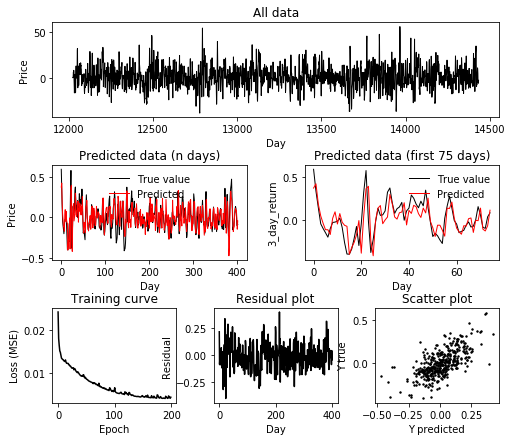

mse=0.01
r2=0.42


In [23]:
# plot the result

plt.figure(figsize=(8,7))

plt.subplot(3, 1, 1)
plt.plot(dataset['3_day_return'], color='black', linewidth=1, label='True value')
plt.ylabel("Price")
plt.xlabel("Day")
plt.title("All data")

plt.subplot(3, 2, 3)
plt.plot(y_test, color='black', linewidth=1, label='True value')
plt.plot(y_pred, color='red', linewidth=1, label='Predicted')
plt.legend(frameon=False)
plt.ylabel("Price")
plt.xlabel("Day")
plt.title("Predicted data (n days)")

# 畫出前 75 天的預測
plt.subplot(3, 2, 4)
plt.plot(y_test[0:75], color='black', linewidth=1, label='True value')
plt.plot(y_pred[0:75], color='red', linewidth=1, label='Predicted')
plt.legend(frameon=False)
plt.ylabel("3_day_return")
plt.xlabel("Day")
plt.title("Predicted data (first 75 days)")

# 訓練曲線，殘插圖，散點圖
plt.subplot(3, 3, 7)
plt.plot(epochs, loss, color='black')
plt.ylabel("Loss (MSE)")
plt.xlabel("Epoch")
plt.title("Training curve")

plt.subplot(3, 3, 8)
plt.plot(y_test - y_pred, color='black')
plt.ylabel("Residual")
plt.xlabel("Day")
plt.title("Residual plot")

plt.subplot(3, 3, 9)
plt.scatter(y_pred, y_test, s=2, color='black')
plt.ylabel("Y true")
plt.xlabel("Y predicted")
plt.title("Scatter plot")

plt.subplots_adjust(hspace=0.5, wspace=0.3)
plt.show()

mse = mean_squared_error(y_test, y_pred)
r2 = r2_score(y_test, y_pred)
print("mse=" + str(round(mse,2)))
print("r2=" + str(round(r2,2)))

In [19]:
# Denormalize the truth value
y_test_df = pd.DataFrame(y_test)
y_test_denorm = de_normalize(y_test_df,y_max,y_min,y_mean)

In [20]:
# Denormalize the predict value
y_pred_df = pd.DataFrame(y_pred)
y_pred_denorm = de_normalize(y_pred_df,y_max,y_min,y_mean)

In [27]:
y_test_denorm.head()

,0
0,43.378995
1,25.000000
2,11.111111
3,-2.229299
4,-6.129032


In [28]:
y_pred_denorm.head()

,0
0,27.691975
1,31.248888
2,14.082991
3,4.354875
4,-1.808623
